In [2]:
import librosa
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm import tqdm_notebook as tqdm

# First piano dataset

Generate a dataset from synthesized piano audio. Audio example below.

In [14]:
ipd.Audio("../../../Samples/Piano/FL/PN_ab-ba_piano.mp3")

In [15]:
y, sr = librosa.load("../../../Samples/Piano/FL/PN_ab-ba_piano.mp3", mono=False)

Convert to mono, downsample to 8000 Hz (we don't need too much precision) and cut the silence at the beginning

In [16]:
y = librosa.core.to_mono(y)
y = librosa.resample(y, sr, 8000)
y = y[np.argwhere(y >= 0.001)[0][0]:]

Read table with note-frequency correspondence

In [17]:
note_table = pd.read_csv("../../../Data/Piano/Note_table.tsv", header=0, sep="\t")
note_table.head()

,Note,Freq
0,C0,16.351598
1,C#0,17.323914
2,D0,18.354048
3,D#0,19.445436
4,E0,20.601722


Convert audio file with several notes to data, picking 16000 samples per individual note

In [18]:
def long_file_to_data(file, rs, note_table):
    y, sr = librosa.load(file, mono=False)
    y = librosa.core.to_mono(y)
    y = librosa.resample(y, sr, rs)
    y = y[np.argwhere(y >= 0.001)[0][0]:]

    df = pd.DataFrame(columns=["x{}".format(i) for i in range(16000)]+["Freq", "Note"])
    notes = list(note_table.iloc[37:72]["Note"])

    for i in tqdm(range(0, 16000*35, 16000), total = 35, leave = False):
        df = df.append(pd.DataFrame({**{"x{}".format(j): [y[j+i]] for j in range(16000)}, 
                                    **{"Freq": [librosa.note_to_hz(notes[int(i/16000)])],
                                      "Note": [notes[int(i/16000)]]}}))
    return df

In [19]:
test = long_file_to_data("../../../Samples/Piano/FL/PN_ab-ba_piano.mp3", 8000, note_table)
test.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x15992,x15993,x15994,x15995,x15996,x15997,x15998,x15999,Freq,Note
0,0.001465,0.001681,0.005331,-0.002838,-0.015286,-0.009736,0.015490,0.010337,0.001405,0.002371,...,0.003488,0.001495,-0.001752,-0.002831,-0.002337,-0.002936,-0.005293,-0.007221,138.591315,C#3
0,-0.008995,-0.013210,-0.014460,-0.016820,-0.016346,-0.013873,-0.015907,-0.014268,-0.007894,-0.003954,...,-0.021490,-0.023198,-0.019781,-0.015293,-0.012494,-0.012988,-0.014049,-0.012630,146.832384,D3
0,-0.009459,-0.008396,-0.008832,-0.012935,-0.010718,-0.002320,-0.002686,-0.000303,0.002634,0.000839,...,-0.001041,-0.000368,0.002192,0.005376,0.007840,0.006027,0.003115,0.003368,155.563492,D#3
0,0.009730,0.016409,0.019472,0.015838,0.014779,0.016792,0.015904,0.019331,0.021950,0.020994,...,-0.009846,-0.014612,-0.016278,-0.014461,-0.012089,-0.009292,-0.008961,-0.012282,164.813778,E3
0,-0.016608,-0.018866,-0.018244,-0.014823,-0.010421,-0.010667,-0.005970,-0.000487,-0.005703,-0.009161,...,-0.017786,-0.018655,-0.018373,-0.018204,-0.018803,-0.017219,-0.015150,-0.011934,174.614116,F3


Now the entire directory with several audio files

In [20]:
def dir_to_data(directory, rs, note_table):
    data = pd.DataFrame(columns=["x{}".format(i) for i in range(16000)]+["Freq", "Note"])
    pbar = tqdm(os.listdir(directory))
    
    for file in pbar:
        pbar.set_description("Processing %s" % file)
        df = long_file_to_data(directory + file, rs, note_table)
        data = data.append(df)
        
    data = data.reset_index().drop("index", axis=1)
    return data

Takes around 6 min

In [21]:
data = dir_to_data("../../../Samples/Piano/FL/", 8000, note_table)

In [22]:
data.sample(5)

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x15992,x15993,x15994,x15995,x15996,x15997,x15998,x15999,Freq,Note
389,-0.025490,-0.025997,-0.025306,-0.033318,-0.037511,-0.032449,-0.027329,-0.024713,-0.019330,-0.010041,...,-0.016998,-0.018817,-0.020256,-0.020247,-0.018280,-0.015150,-0.011621,-0.009318,174.614116,F3
492,-0.006904,-0.007439,-0.005200,-0.004706,-0.005079,-0.004594,-0.004922,-0.005620,-0.003838,-0.009430,...,0.025088,0.024729,0.024715,0.024384,0.023154,0.021338,0.019265,0.018084,155.563492,D#3
469,0.002501,0.003953,0.000369,-0.007325,-0.009564,-0.012282,-0.008993,-0.016064,-0.016349,-0.012625,...,0.006157,0.005498,0.007216,0.010246,0.007591,0.009836,0.012352,0.010439,311.126984,D#4
626,0.002890,-0.001390,-0.004018,-0.000696,0.000018,-0.004573,-0.000948,0.008294,0.009885,0.007812,...,-0.000159,-0.002138,-0.004113,-0.004174,-0.007297,-0.005261,-0.009861,-0.009737,830.609395,G#5
87,0.004213,0.003973,0.004064,0.002339,0.001023,-0.002601,-0.001177,0.001681,-0.000356,-0.006283,...,-0.001016,-0.000241,0.000519,0.001012,0.000212,-0.001021,-0.003240,-0.005342,369.994423,F#4


In [11]:
data.shape

(700, 16002)

Saving and testing...

In [12]:
data.drop("Note", axis=1).to_csv("data_freq.tsv", index=False, sep="\t")

In [13]:
data.drop("Freq", axis=1).to_csv("data_note.tsv", index=False, sep="\t")

In [2]:
data = pd.read_csv("data_freq.tsv", sep="\t", header=0)

In [5]:
data.drop("Freq", axis=1).iloc[0].values

array([ 0.0014648 ,  0.00168076,  0.00533115, ..., -0.00293616,
       -0.0052928 , -0.00722118])

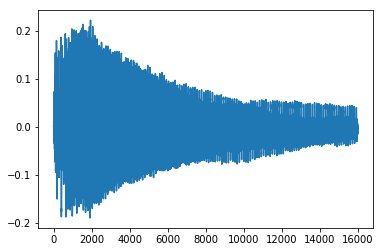

In [7]:
plt.plot(data.drop("Freq", axis=1).iloc[0].values)